## This document analyzes Rate My Hydrograph metadata on users and their ratings.

In [1]:
import math
from collections import defaultdict
from datetime import datetime

import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rc('font', **{'family':'serif','serif': ['Computer Modern']})
plt.rcParams.update({"text.usetex": True,})
plt.rc('font', size=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)

df = pd.read_csv('data/rmh-stage1.csv', index_col=0)
df['sum'] = list(range(df.shape[0]))

mm_to_inch = lambda mm: mm * 0.03937008

In [2]:
print(f'There are {df["user_id"].unique().shape[0]} users who rated hydrographs.')
print(f'In total, they generated {df.shape[0]} ratings.')

There are 622 users who rated hydrographs.
In total, they generated 14586 ratings.


Let's look at the number of possible settings. A "setting" is defined as a tuple (basin, models, date range, objective, task)

In [3]:
# Some basins occur in both objectives, but this counts as two settings.
basins_objectives = df.groupby('objective')['basin'].nunique().values
n_combinations = math.comb(df['model_a'].nunique(), 2) * basins_objectives.sum() * df['start_date'].nunique() * df['task'].nunique()
print(f'There are {df["model_a"].nunique()} models, {basins_objectives.sum()} basin-objective combinations across the {df["objective"].nunique()} GRIP-GL objectives (low human impact & most downstream), '
      f'{df["start_date"].nunique()} date ranges, and {df["task"].nunique()} tasks.')
print(f'This means there are {n_combinations} possible settings.')

There are 13 models, 170 basin-objective combinations across the 2 GRIP-GL objectives (low human impact & most downstream), 5 date ranges, and 3 tasks.
This means there are 198900 possible settings.


Next, let's see how many ratings each user submitted:

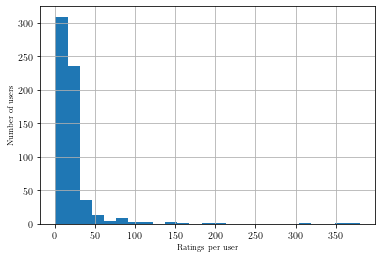

In [4]:
# votes per user
df.groupby('user_id')['id'].count().hist(bins=25)
plt.xlabel('Ratings per user')
_ = plt.ylabel('Number of users')

Next, we'll take a look at how the ratings accumulated over time:

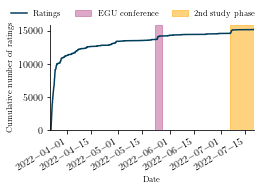

In [5]:
# Additionally load ratings from stage 2
phase2_df = pd.read_csv('data/rmh-stage2.csv', index_col=0)
all_df = pd.concat([df, phase2_df], ignore_index=True)
all_df['sum'] = list(range(all_df.shape[0]))

colors = ['#003f5c', '#bc5090', '#ffa600']
plot_df = all_df.sort_values(by="last_modified").copy()
plot_df['last_modified'] = pd.to_datetime(plot_df['last_modified'])
plot_df.plot("last_modified", "sum", legend=False, label='Ratings', color=colors[0], figsize=(mm_to_inch(95), mm_to_inch(70)))
plt.ylabel('Cumulative number of ratings')
plt.xlabel('Date')

max_date = plot_df['last_modified'].max()
plt.axvspan(pd.to_datetime("2022-05-23"), pd.to_datetime("2022-05-27"), alpha=0.5, color=colors[1], label='EGU conference')
plt.axvspan(pd.to_datetime("2022-07-06"), max_date, alpha=0.5, color=colors[2], label='2nd study phase')
plt.ylim(0, None)
plt.xlim(pd.to_datetime('2022-03-22'), max_date)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(frameon=False, ncol=3, bbox_to_anchor=(-0.23, 1, 1.27, 0), loc="lower left", mode="expand")
plt.tight_layout()

plt.savefig('figures/participation.pdf', bbox_inches='tight')

## Experience and focus areas

Let's look at the experience and focus areas of participants

In [6]:
# Load users from stage 1
udf = pd.read_csv('data/rmh-users.csv', index_col=0)
udf = udf[udf['id'].isin(df['user_id'])]

In [7]:
udf.groupby("occupation")["id"].count()

occupation
academia         408
industry          92
public-sector    122
Name: id, dtype: int64

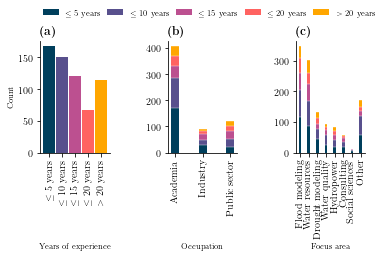

In [8]:
index = ['flood-modeling', 'water-resources', 'drought-modeling', 'waterquality', 'hydropower', 'consulting', 'social-sciences', 'other']
labels = ['Flood modeling', 'Water resources', 'Drought modeling', 'Water quality', 'Hydropower', 'Consulting', 'Social sciences', 'Other']
occupations = ['academia', 'industry', 'public-sector']
occ_labels = ['Academia', 'Industry', 'Public sector']

years_areas_dict = {}
years_occupation_dict = {}
prev_years = -1
bottom = np.zeros(len(index))
bottom_occupation = np.zeros(len(occupations))

f, axs = plt.subplots(1, 3, figsize=(mm_to_inch(139), mm_to_inch(70)))
colors = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']

# Histogram of years experience
plot_udf = udf.copy()
plot_udf['years_experience'] = plot_udf['years_experience'].clip(upper=25)
years = [0, 5, 10, 15, 20, 25]
_, _, patches = axs[0].hist(plot_udf["years_experience"], bins=years, align='left', rwidth=0.9)
for i, patch in enumerate(patches):
    patch.set_facecolor(colors[i])
axs[0].set_xlabel("Years of experience")
axs[0].set_ylabel("Count")
axs[0].set_xticks(years[:-1])
years_label = []
for year in years[1:]:
    label = f'$\leq$ {year} year{"s" if year > 1 else ""}'
    if year == years[-1]:
        label = f'$>$ {years[-2]} years'
    years_label.append(label)
axs[0].set_xticklabels(years_label, rotation='vertical')

# Histograms of occupation and focus area, split by years experience
# Focus areas are one column with comma-separated values. This command splits the areas into individual columns.
years_areas = pd.concat([udf["focus_areas"].str.split(',').apply(pd.Series), udf['years_experience']], axis=1)
for i, years in enumerate([5, 10, 15, 20, 999999]):
    years_label = f'$\leq$ {years} year{"s" if years > 1 else ""}'
    if years == 999999:
        years_label = f'$>$ {prev_years} years'
    
    # Get users with the current years experience, melt the columns into rows.
    sub_df = years_areas[(years_areas['years_experience'] <= years) \
        & (years_areas['years_experience'] > prev_years)] \
            .drop('years_experience', axis=1).melt()['value']
    
    # Count the number of users that fit the current years bin, grouped by the different focus areas.
    fa_count = pd.Series(index=index, data=[sub_df[sub_df == v].shape[0] for v in index])
    fa_count['other'] += sum([sub_df[sub_df == v].shape[0] for v in sub_df.unique() 
                              if v not in index and v != 'NaN' and not pd.isna(v)])
    years_areas_dict[years] = fa_count

    axs[2].bar(labels, fa_count.values, width=0.3, bottom=bottom, color=colors[i], label=years_label, yerr=0, capsize=3, ecolor='white', error_kw={'capthick': 0.2})
    axs[2].set_xlabel('Focus area')
    bottom += fa_count.values
    
    # Plot occupation by years experience
    sub_df = udf[(udf['years_experience'] <= years) \
        & (udf['years_experience'] > prev_years)]
    occ_count = pd.Series(index=occupations, data=[sub_df[sub_df["occupation"] == v].shape[0] for v in occupations])
    years_occupation_dict[years] = occ_count
    axs[1].bar(occ_labels, occ_count.values, width=0.3, bottom=bottom_occupation, color=colors[i], yerr=0, capsize=5, ecolor='white', error_kw={'capthick': 0.2})
    axs[1].set_xlabel('Occupation')
    bottom_occupation += occ_count.values

    prev_years = years
plt.tight_layout()
plt.figlegend(frameon=False, ncol=5, bbox_to_anchor=(0.1, 1.03, 0.88, 0), loc="lower left", mode="expand")
for i, (ax, title) in enumerate(zip(axs, 'abc')):
    ax.set_title(f'\\textbf{{({title})}}', loc='left')
    if i > 0:
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(labels if i == 2 else occ_labels, rotation='vertical')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
f.align_xlabels()
f.savefig('figures/histograms.pdf', bbox_inches='tight')

## Map of users

Let's look at a map showing where in the world our users are coming from:

Plot is not showing: Aland Islands, American Samoa, Hong Kong, Liechtenstein


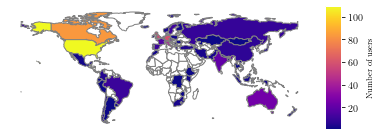

In [9]:
# Map of users
fig, ax = plt.subplots(1, 1, figsize=(mm_to_inch(139), mm_to_inch(70)))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

countries = udf.groupby("country")["id"].count()
# Some countries have different names in our data vs. in geopandas.
country_conversion = {"United States": "United States of America", "Russian Federation": "Russia", 
                              "Taiwan Province of China": "Taiwan", "Iran Islamic Republic of": "Iran", 
                              "Viet Nam": "Vietnam", "Czech Republic": "Czechia", 
                              'Congo Democratic Republic of the Congo': "Dem. Rep. Congo"}
countries = countries.rename(country_conversion)
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
# We can't plot a few countries, but they're so tiny that it doesn't matter.
print("Plot is not showing:", ', '.join([c for c in countries.index if c not in world["name"].values]))

cpt = world.join(countries, on="name")
# If there are no users, remove Antarctica to make the plot look better
if "Antarctica" not in countries.index:
    cpt = cpt[cpt["name"] != "Antarctica"]
with plt.style.context(("seaborn", "ggplot")):
    cpt.plot("id",edgecolor="gray",cmap=plt.cm.plasma, linewidth=1, missing_kwds={"color": "white"}, legend=True, legend_kwds={"label": "Number of users"}, cax=cax, ax=ax)
    ax.axis('off')
    plt.tight_layout()

Plot is not showing: Aland Islands, American Samoa, Hong Kong, Liechtenstein


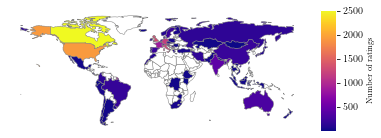

In [10]:
# Map of ratings
fig, ax = plt.subplots(1, 1, figsize=(mm_to_inch(139), mm_to_inch(70)))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

countries = df.groupby("country").count().iloc[:,0]
# Some countries have different names in our data vs. in geopandas.
countries = countries.rename(country_conversion)
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
# We can't plot a few countries, but they're so tiny that it doesn't matter.
print("Plot is not showing:", ', '.join([c for c in countries.index if c not in world["name"].values]))

cpt = world.join(countries, on="name")
# If there are no ratings, remove Antarctica to make the plot look better
if "Antarctica" not in countries.index:
    cpt = cpt[cpt["name"] != "Antarctica"]
with plt.style.context(("seaborn", "ggplot")):
    cpt.plot("id", edgecolor="gray", cmap=plt.cm.plasma, linewidth=0.5, missing_kwds={"color": "white"}, legend=True, legend_kwds={"label": "Number of ratings"}, cax=cax, ax=ax)
    ax.axis('off')
    plt.tight_layout()
plt.savefig('figures/ratings-map.pdf', bbox_inches='tight')